# Signal vs. background classification in NEXT

In [1]:
%matplotlib inline

import os
import matplotlib        as mpl
import matplotlib.pyplot as plt
import numpy             as np
import tables            as tb

from glob    import glob
from IPython import display

import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim

from torch.autograd   import Variable
from torch.autograd   import Function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchsummary import summary

mpl.rcParams.update({'font.size': 14})

#### Enable/disable CUDA

In [2]:
CUDA_available = torch.cuda.is_available()
print("CUDA Available:", CUDA_available)

enable_CUDA  = True                                # enable CUDA by default if it is available
CUDA_enabled = (enable_CUDA and CUDA_available)
if (CUDA_enabled):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    
print("CUDA Enabled  :", CUDA_enabled)

CUDA Available: False
CUDA Enabled  : False


#### Download the data

In [3]:
!wget -O background.h5 https://www.dropbox.com/s/twrlgugolrmuqyr/background.h5?dl=0
!wget -O signal.h5 https://www.dropbox.com/s/10i52opac7j7fpx/signal.h5?dl=0

--2020-05-29 19:11:35--  https://www.dropbox.com/s/twrlgugolrmuqyr/background.h5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/twrlgugolrmuqyr/background.h5 [following]
--2020-05-29 19:11:35--  https://www.dropbox.com/s/raw/twrlgugolrmuqyr/background.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc34fe1d9abaded5ef535e1f0f12.dl.dropboxusercontent.com/cd/0/inline/A4q4WdGcAHxfFsPJ6vdl2RFPnkZQSYJjuHsSQOYtAdJIGI9mxDbFO8-BXyQyCsJGulO7bPJud2sDL30-NJNQxOGuyhTylDQ_SFGhPn4rX9o1pwMGdmo9sMM-ReMYEf-imqo/file# [following]
--2020-05-29 19:11:35--  https://uc34fe1d9abaded5ef535e1f0f12.dl.dropboxusercontent.com/cd/0/inline/A4q4WdGcAHxfFsPJ6vdl2RFPnkZQSYJjuHsSQOYtAdJIGI9mxDbFO8-BXyQyCsJGulO7bPJud2sDL30-NJNQxOGuyhTylDQ_SFGhPn4rX9o1pwMGdmo9sMM-ReMYEf-imqo

## Definition of key variables
The directory structure followed is:

`$NEXTHOME/data`   -- contains datafiles `signal.h5` and `background.h5`<br>
`$NEXTHOME/models` -- contains saved models

In [4]:
# data dimensions
xdim = 20
ydim = 20
zdim = 60

# directory structure
modelsdir = "models"
if(not os.path.isdir(modelsdir)):
    os.mkdir(modelsdir)

datafile_signal     = "signal.h5"
datafile_background = "background.h5"

## Preview events
The events are 20x20x60 maps of simulated voxelized tracks. One can get a good idea of what these tracks look like by summing over the z-dimension and plotting this projection in x-y.

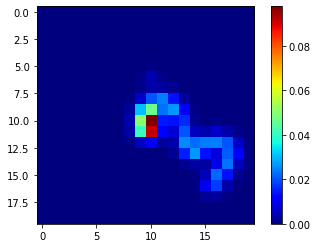

In [5]:
evtnum = 0

with tb.open_file(datafile_background, "r") as file:
    event = file.root.maps[evtnum]

plt.imshow(np.sum(event,axis=2),cmap='jet')
plt.imshow(np.sum(event,axis=2),cmap='jet')
plt.colorbar();

## Data preparation
Here a Pytorch `Dataset` is created for batching 3D maps of NEXT track topologies. The files containing signal and background events are provided, followed by a range of events. The idea is that the training, validation, and test sets can be created using events from the same files via differing ranges of events. The flag `load_to_memory`, when set to `True`, loads all events into memory at once for faster batching.

In [6]:
class NEXTDataset(Dataset):
    
    def __init__(self, datafile_signal, datafile_background, nstart=0, nend=0, load_to_memory=True):
        
        # Save inputs for later use.
        self.datafile_signal     = datafile_signal
        self.datafile_background = datafile_background
        self.load_to_memory      = load_to_memory
        
        # Read datafiles and get the tracks
        signal     = tb.open_file(datafile_signal    , "r").root.maps 
        background = tb.open_file(datafile_background, "r").root.maps
        
        # Get the number of signal and background events and ensure that we have the same.
        nsignal     = signal    .shape[0]
        nbackground = background.shape[0]
        nmin        = min(nsignal, nbackground)
        
        # Ensure nend > nstart.
        if (nend <= nstart):
            nend = nmin
            
        # Load everything at once.
        if (load_to_memory):
            self.data   = np.vstack((signal[nstart:nend]      , background[nstart:nend]))
            self.labels = np.vstack((np.ones((nend-nstart, 1)), np.zeros((nend-nstart, 1))))
                                    
        # Save the final values of nstart and nend.
        self.nstart = nstart
        self.nend   = nend
        
        print("Created dataset from events", nstart, "to", nend, "of", nmin, "available signal and background events")

    def __len__(self):
        return 2*(self.nend-self.nstart)

    def __getitem__(self, idx):
        # Choose the data, label pair at the specified index if everything is already loaded into memory.
        if (self.load_to_memory):
            event = torch.tensor(self.data  [idx]).float()
            label = torch.tensor(self.labels[idx]).float()
        
        # Otherwise find the event in the correct file.
        else:
            # Second half of indices correspond to background.
            nrange = (self.nend-self.nstart)
            if(idx >= nrange):
                datafile = self.datafile_background
                idx     -= nrange
                label    = torch.tensor([0]).float()
            else:
                datafile = self.datafile_signal
                label    = torch.tensor([1]).float()

            # Open the correct file and extract the element corresponding to this index.
            with tb.open_file(datafile, "r") as file:
                event = torch.tensor(file.root.maps[idx])
                
        return event, label

In [7]:
Dataset = NEXTDataset(datafile_signal, datafile_background, nstart=0, nend=10)

Created dataset from events 0 to 10 of 35707 available signal and background events


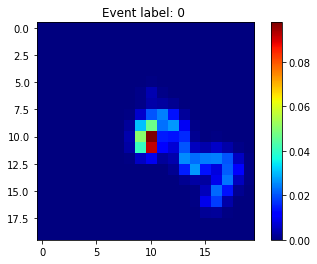

In [8]:
event, label = Dataset[10]

plt.title(f"Event label: {int(label.item())} ")
plt.imshow(event.sum(dim=2), cmap='jet')
plt.imshow(event.sum(dim=2), cmap='jet')
plt.colorbar();

## Create a neural network
Here the neural network architecture is defined.

In [9]:
class FCNet(nn.Module):

    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(xdim*ydim*zdim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        return x

In [10]:
net = FCNet()
if(CUDA_enabled):
    net = net.cuda()
summary(net, (xdim, ydim, zdim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]         768,032
            Linear-2                    [-1, 1]              33
Total params: 768,065
Trainable params: 768,065
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 0.00
Params size (MB): 2.93
Estimated Total Size (MB): 3.02
----------------------------------------------------------------


## Train the network
Here functions for network training and validation are defined.

In [11]:
verbose = True

def train():
    losses_epoch, accuracies_epoch = [], []
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if(CUDA_enabled):
            data, target = data.cuda(), target.cuda()
        
        # optimizer zero grad
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        # Compute the accuracy.
        acc = (torch.sigmoid(outputs) > 0.5) == (target > 0.5)
        acc = acc.squeeze().numpy().sum() / len(acc)
        
        accuracies_epoch.append(acc)
        losses_epoch.append(loss.item())

        if verbose and (batch_idx % 10 == 0):
            progress = f"Train Epoch: {epoch} [{batch_idx*batch_size:05}/{len(train_loader.dataset)}" +\
                       f" ({int(100*batch_idx/len(train_loader)):02}%)]"
            loss_ = f"\t Loss: {loss.item():.6f}"
            print(progress + loss_)
            
    return losses_epoch, accuracies_epoch


def val():
    losses_epoch, accuracies_epoch = [], []
    for batch_idx, (data, target) in enumerate(val_loader):
        
        if(CUDA_enabled):
            data, target = data.cuda(), target.cuda()

        # Compute the model result.
        outputs = model(data)
        
        # Compute the loss.
        loss = criterion(outputs, target)
        
        # Compute the accuracy.
        acc = (torch.sigmoid(outputs) > 0.5) == (target > 0.5)
        acc = acc.squeeze().numpy().sum() / len(acc)

        accuracies_epoch.append(acc)
        losses_epoch.append(loss.data.item())
        
    return losses_epoch, accuracies_epoch

Create datasets and data loaders for training and validation.

In [12]:
batch_size = 200
nstart_train, nend_train = 0   , 25000
nstart_val  , nend_val   = 25000, 30000

dataset_train = NEXTDataset(datafile_signal, datafile_background, nstart_train, nend_train)
train_loader  = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val   = NEXTDataset(datafile_signal, datafile_background, nstart_val, nend_val)
val_loader    = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

Created dataset from events 0 to 25000 of 35707 available signal and background events
Created dataset from events 25000 to 30000 of 35707 available signal and background events


Set some key flags for training:
- **load_model**: set to True to load the specified model. If training is True, the model will be loaded before any training begins.
- **modelfile**: the model to be loaded
- **training**: set to True to perform training
- **lrate**: the learning rate to use for training

Note: to perform testing with an already trained model, set `load_model` to `True` and `training` to `False`.

In [13]:
epochs = 10
lrate  = 1e-2
load_model = False
training   = True
modelfile  = f"{modelsdir}/model_NEXT_0.pt"

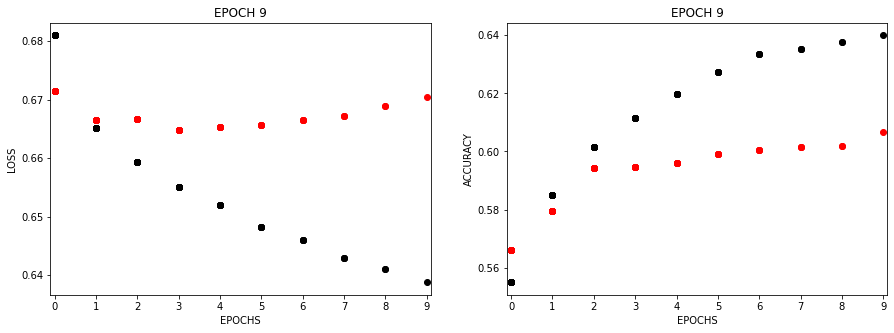

In [14]:
x = np.arange(epochs)
train_losses = np.full(len(x), np.nan)
val_losses   = np.full(len(x), np.nan)
train_accuracies = np.full(len(x), np.nan)
val_accuracies   = np.full(len(x), np.nan)

fig = plt.figure(figsize=[15, 5])
ax0 = fig.add_subplot(121) 
ax1 = fig.add_subplot(122)
ax0.set_xlabel("EPOCHS")
ax1.set_xlabel("EPOCHS")
ax0.set_ylabel("LOSS")
ax1.set_ylabel("ACCURACY")
ax0.set_xlim([-0.1, epochs-1 + 0.1])
ax1.set_xlim([-0.1, epochs-1 + 0.1])
ax0.set_xticks(range(0, epochs))
ax1.set_xticks(range(0, epochs))

# Create your net
model = FCNet()

# Choose an Optimizer and a Loss
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0)

if (CUDA_enabled):
    model.cuda()

# Load the model from file.
if (load_model):
    model.load_state_dict(torch.load(modelfile))
    model.eval()

# Train the model.
if (training):
    for epoch in range(0, epochs):
        model.train()
        losses_epoch, accuracies_epoch = train()
        train_losses[epoch] = np.mean(losses_epoch)
        train_accuracies[epoch] = np.mean(accuracies_epoch)
        with torch.no_grad():
            model.eval()
            losses_epoch, accuracies_epoch = val()
            val_losses[epoch] = np.mean(losses_epoch)
            val_accuracies[epoch] = np.mean(accuracies_epoch)
    
        # save model in epoch
        torch.save(model.state_dict(), f"{modelsdir}/model_NEXT_{epoch}.pt")
        
        # update plot
        ax0.set_title(f"EPOCH {epoch}")
        ax0.scatter(x, train_losses, c="black")
        ax0.scatter(x, val_losses  , c="red")
        
        ax1.set_title(f"EPOCH {epoch}")
        ax1.scatter(x, train_accuracies, c="black")
        ax1.scatter(x, val_accuracies  , c="red")

        display.clear_output(wait=True)
        display.display(fig)
        
display.clear_output()

## Test the model
Create a test dataset and loader

In [15]:
nstart, nend = 30000, 35000

dataset_test  = NEXTDataset(datafile_signal, datafile_background, nstart, nend)

Created dataset from events 30000 to 35000 of 35707 available signal and background events


Run the model on each data sample.

In [16]:
signal, _     = dataset_test[:nstart-nend]
background, _ = dataset_test[nstart-nend:]
if(CUDA_enabled):
    signal,background = signal.cuda(), background.cuda()

In [17]:
sigmoid = nn.Sigmoid()

with torch.no_grad():
    signal_predictions     = sigmoid(model(signal))
    background_predictions = sigmoid(model(background))
    
signal_predictions     = signal_predictions    .cpu().squeeze().numpy()
background_predictions = background_predictions.cpu().squeeze().numpy()

Plot model prediction distributions

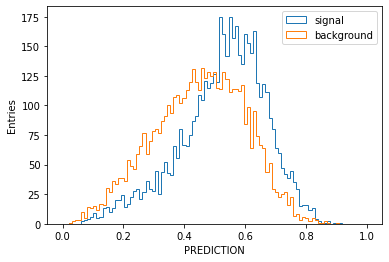

In [18]:
plt.hist(signal_predictions    , bins=np.linspace(0, 1, 100), histtype="step", label="signal")
plt.hist(background_predictions, bins=np.linspace(0, 1, 100), histtype="step", label="background")
plt.xlabel("PREDICTION");
plt.ylabel("Entries")
plt.legend();

Compute the signal efficiency vs. background rejection for several thresholds.
- the **signal efficiency** is the number of correctly predicted (prediction >= threshold) signal events divided by the total number of signal events
- the **background rejection** is the number of correctly predicted (prediction < threshold) background events divided by the total number of background events

In [19]:
npoints = 100
signal_eff, background_rej = [],[]

for th in np.arange(0, 1, 1./npoints):
    
    # Get the total number of each class.
    N_signal     = len(signal_predictions)
    N_background = len(background_predictions)
    
    # Get the number of correctly classified for each class.
    correct_signal     = np.sum(signal_predictions     >= th)
    correct_background = np.sum(background_predictions <  th)
    
    signal_eff    .append(1.0*correct_signal    /N_signal)
    background_rej.append(1.0*correct_background/N_background)

Plot the results.

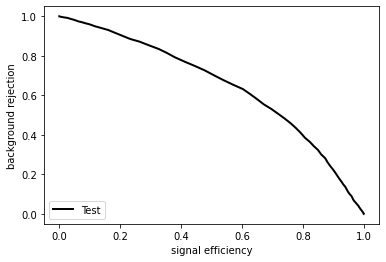

In [20]:
plt.plot(signal_eff, background_rej,color='black',label='Test', lw=2)
plt.xlabel("signal efficiency")
plt.ylabel("background rejection")
plt.legend(loc=3);